In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ee
import geopandas as gp
import rsfuncs as rs
import datetime
import importlib

from shapely.geometry import Point

%load_ext autoreload
%autoreload 2

ee.Initialize()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
pt = pd.read_csv("../shapefiles/Sequoia_Disk.txt", skiprows = 2, sep = "\t")
gdf = gp.GeoDataFrame(
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(pt.lon, pt.lat)])

In [12]:
# convert km to decimal degrees
radius_dd =  30 / 111.32
poly = gdf.buffer(radius_dd)

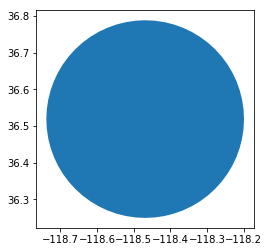

In [13]:
poly.plot()

In [14]:
data = rs.load_data()

In [15]:
years = range(2016, 2018)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [16]:
area = rs.gdf_to_ee_poly(poly)

In [17]:
"""
Pull soil moisture from :
1. smap (25 km resolution), 3 day revisit, units = % 
2. gldas root zone soil moisture (25 km resolution), 3 hourly product, units = kg/m^2
3. terraclimate (4 km resolution), monthly product, units = mm

"""

'\nPull soil moisture from :\n1. smap (25 km resolution), 3 day revisit, units = % \n2. gldas root zone soil moisture (25 km resolution), 3 hourly product, units = kg/m^2\n3. terraclimate (4 km resolution), monthly product, units = mm\n\n'

In [18]:
smap = rs.get_ims(data['smap_smp'], years, months, area)
tc_sm = rs.get_ims(data['tc_sm'], years, months, area)
gldas = rs.get_ims(data['gldas_sm'], years, months, area)

processing
0.0 % 
20.0 % 
40.0 % 
60.0 % 
80.0 % 
postprocesing
processing
0.0 % 
20.0 % 
40.0 % 
60.0 % 
80.0 % 
postprocesing
processing
0.0 % 
20.0 % 
40.0 % 
60.0 % 
80.0 % 
postprocesing


/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


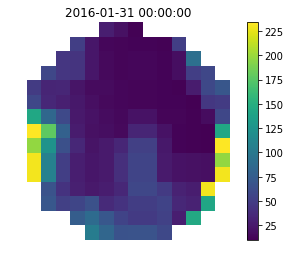

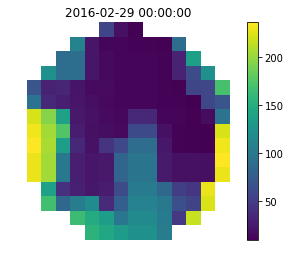

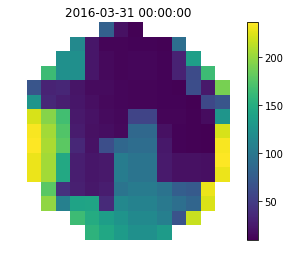

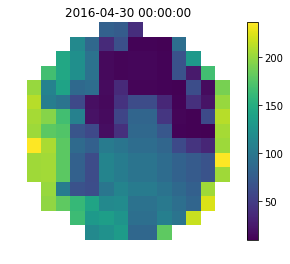

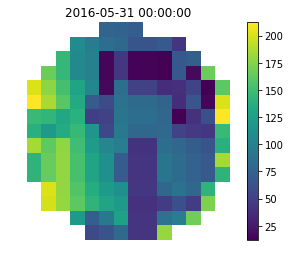

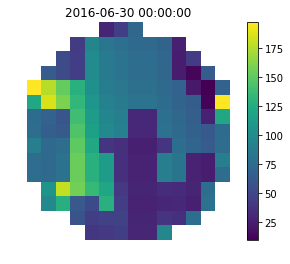

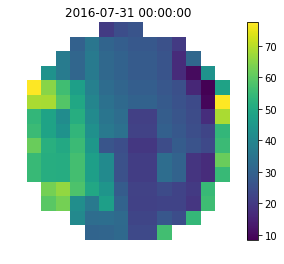

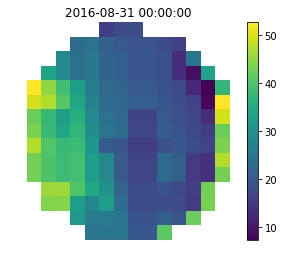

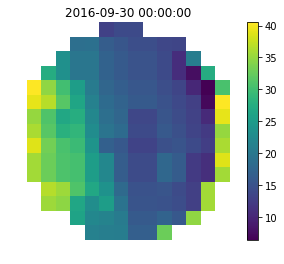

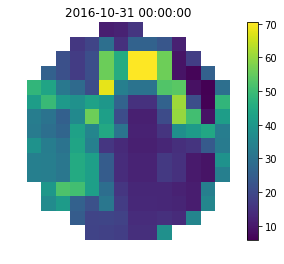

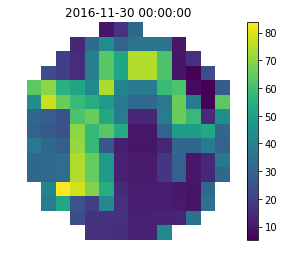

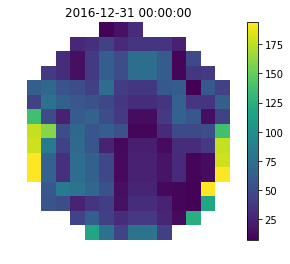

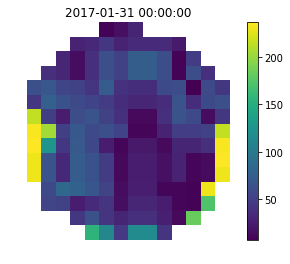

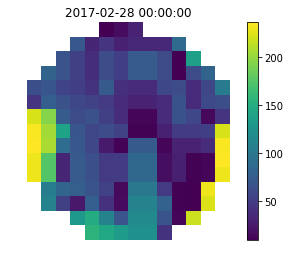

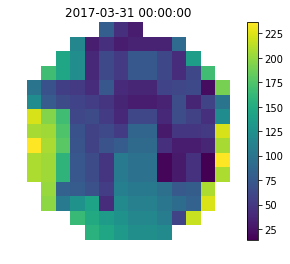

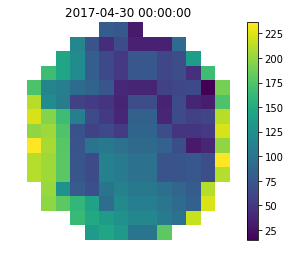

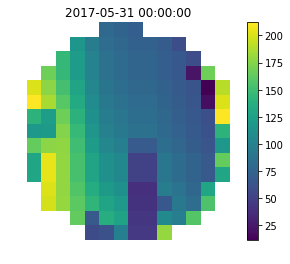

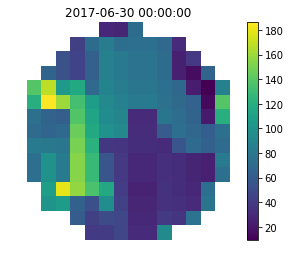

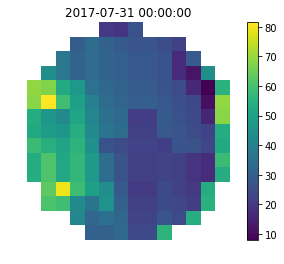

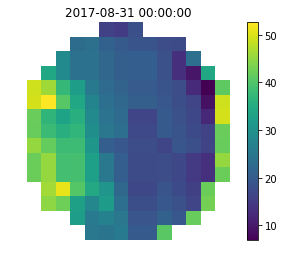

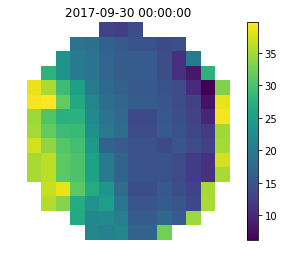

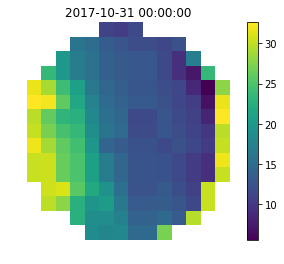

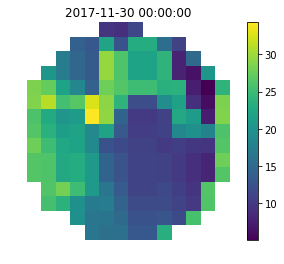

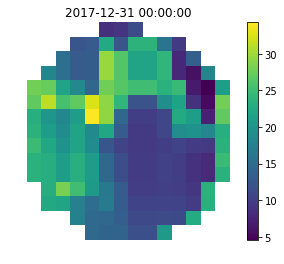

In [19]:
# Sanity check: plot the monthly means for terraclimate. These are in mm/pixel 

means = []
for i in zip(dt_idx,tc_sm):
    plt.title(str(i[0]))
    plt.imshow(np.nanmean(i[1], axis = 0)* data['tc_sm'][2]) # Scale by 0.01
    plt.colorbar()
    plt.axis("off")
    plt.show()

In [20]:
# To get in the format you want, supply the table = True arg

smap = rs.get_ims(data['smap_smp'], years, months, area, table = True)
tc_sm = rs.get_ims(data['tc_sm'], years, months, area, table = True)
gldas = rs.get_ims(data['gldas_sm'], years, months, area, table = True)

processing
0.0 % 
20.0 % 
40.0 % 
60.0 % 
80.0 % 
postprocesing
processing
0.0 % 
20.0 % 
40.0 % 
60.0 % 
80.0 % 
postprocesing
processing
0.0 % 
20.0 % 
40.0 % 
60.0 % 
80.0 % 
postprocesing


In [21]:
# Apply the scaling factor to terraclimate
for i in tc_sm:
    i.soil = i.soil*data['tc_sm'][2]

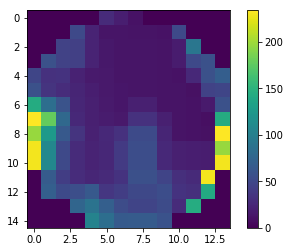

In [22]:
# Another sanity check 
plt.imshow(rs.array_from_df(pd.DataFrame(tc_sm[0]), data['tc_sm'][1]))
plt.colorbar()

In [23]:
# Concatenate the monthly dataframes
gldas = pd.concat(gldas)
tc_sm = pd.concat(tc_sm)
smap = pd.concat(smap)

In [24]:
# Now you have:
#the times in the "id" col
# lat / long  cols
# and the SM values in different units in the trailing cols
gldas.head()

,id,longitude,latitude,time,RootMoist_inst
1,A20160101_0000,-118.465,36.2695,1.45161e+12,70.925
2,A20160101_0300,-118.465,36.2695,1.45162e+12,70.925
3,A20160101_0600,-118.465,36.2695,1.45163e+12,70.925
4,A20160101_0900,-118.465,36.2695,1.45164e+12,70.925
5,A20160101_1200,-118.465,36.2695,1.45165e+12,70.925


In [25]:
tc_sm.head()

,id,longitude,latitude,time,soil
1,201601,-118.56,36.274,1.45161e+12,105.8
2,201601,-118.524,36.274,1.45161e+12,104.4
3,201601,-118.488,36.274,1.45161e+12,84.3
4,201601,-118.452,36.274,1.45161e+12,66.3
5,201601,-118.416,36.274,1.45161e+12,67


In [26]:
smap.head()

,id,longitude,latitude,time,smp
1,NASA_USDA_SMAP_SM20160103_20160105,-118.465,36.2695,1.45178e+12,0.688276
2,NASA_USDA_SMAP_SM20160106_20160108,-118.465,36.2695,1.45204e+12,0.760599
3,NASA_USDA_SMAP_SM20160109_20160111,-118.465,36.2695,1.4523e+12,0.780304
4,NASA_USDA_SMAP_SM20160112_20160114,-118.465,36.2695,1.45256e+12,0.770087
5,NASA_USDA_SMAP_SM20160115_20160117,-118.465,36.2695,1.45282e+12,0.778633


In [27]:
# write to file like this: 
smap.to_csv("../data/smap_16_18.csv")
tc_sm.to_csv("../data/tc_sm_16_18.csv")
gldas.to_csv("../data/gldas_sm_16_18.csv")